In [1]:
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = 16, 6
import numpy as np

# Face Detection
Applying Viola-Jones based face detection in OpenCV is very simple. All you need is:
1. Obtain a trained face detection cascade
2. Apply cascade in various scales

## Face Cascade
The complete OpenCV installation comes with some very useful cascades: https://github.com/Itseez/opencv/tree/2.4.12.3/data/haarcascades
Some of these cascades are for frontal face. In addition there are frontal face detection cascades that use LBP features. The cascade we will use here is: haarcascade_frontalface_default.xml

The cascade is an XML file that describes the weak classifiers learned parameters, and the HAAR features used. We will soon inspect its contents, but first lets use it.

### Using the Cascade

found 1 faces


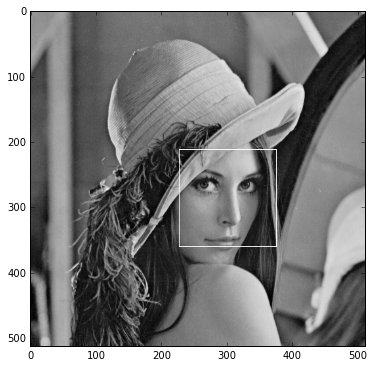

In [2]:
import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
lena = cv2.imread('lena.png', 0) # Load as gray
rects = face_cascade.detectMultiScale(lena, 
                                      minSize=(64,64), # Smallest window
                                      maxSize=(180, 180), # Largest window
                                      scaleFactor=1.1, # Step between windoes
                                      minNeighbors=1) # how many neighbors each candidate rectangle should have
print 'found %d faces' % len(rects)

for rect in rects:
    cv2.rectangle(lena, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), 255)

imshow(lena); gray();

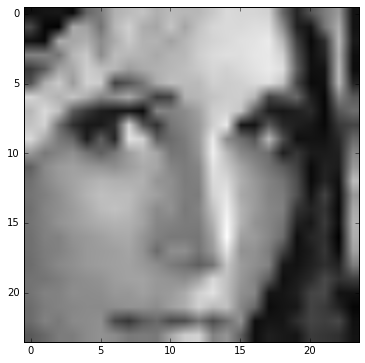

In [3]:
lena_face_img = cv2.resize(lena[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])], dsize=(24,24), interpolation=cv2.INTER_CUBIC)
imshow(lena_face_img);

## Live face detection

In [4]:
video_capture = cv2.VideoCapture(0)
while True:
    state, img = video_capture.read()
    if not state:
        # 'Video is over'
        break
    rects = face_cascade.detectMultiScale(img, 
                                          minSize=(64,64), # Smallest window
                                          maxSize=(180, 180), # Largest window
                                          scaleFactor=1.5, # Step between windoes
                                          minNeighbors=2) # how many neighbors each candidate rectangle should have
    for rect in rects:
        cv2.rectangle(img, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0))
    
    cv2.imshow(winname='frame', mat=img)
    key = cv2.waitKey(1) # Wait for 30 milliseconds

    if key == ord('q'):
        # The key 'q' has been pressed
        break
cv2.destroyWindow('frame')
del video_capture

## Analyzing the Cascade
The cascade can be treated as a black box which magically finds faces. Luckily the cascade as represented as a somewhat readable XML file which we can inspect.

In [5]:
import xml.etree.ElementTree
tree = xml.etree.ElementTree.ElementTree()
root = tree.parse('haarcascade_frontalface_default.xml')
features = root.find('.//features')
print 'total number of features used in cascade:', len(list(features))
print 'total stages in cascade:', len(list(root.find('.//stages')))


total number of features used in cascade: 2913
total stages in cascade: 25


lets examine the first stage

In [6]:
first_stage_weak_classifiers = list(root.find('.//stages'))[0].find('weakClassifiers')
print 'First stage weak classifiers:', len(list(first_stage_weak_classifiers))
first_stage_features = [int(x.text.strip().split(' ')[2]) for x in first_stage_weak_classifiers.findall('.//internalNodes')]

First stage weak classifiers: 9


Now let's visualize the features of the first cascade by parsing the feature part of the xml:

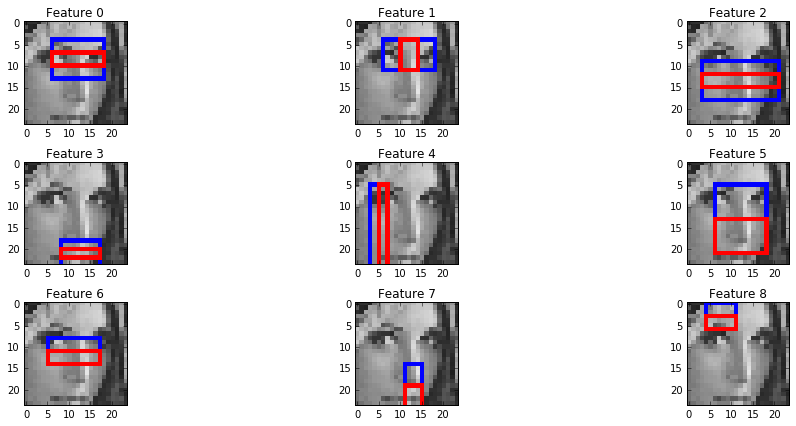

In [7]:
def show_feature(feature_tag):
    canvas = np.dstack([lena_face_img]*3)
    for rect_tag in feature_tag.findall('.//rects/_'):
        tokens = rect_tag.text.strip().split(' ')
        rect = [int(x) for x in tokens[:4]]
        weight = float(tokens[-1])
        cv2.rectangle(canvas, tuple(rect[:2]), (rect[0]+rect[2], rect[1]+rect[3]), color=(255,0,0) if weight > 0 else (0,0,255), thickness=1)
    return canvas

for i in first_stage_features:
    canvas = show_feature(features[i])
    subplot(3,3,i+1)
    title('Feature %d' % i)
    imshow(canvas, interpolation='nearest')
tight_layout()